<a href="https://colab.research.google.com/github/nthanhtin/forestfires/blob/master/forestfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code for our group project in predicting forest fire using the data set from:

https://archive.ics.uci.edu/ml/datasets/forest+fires

Dataset dimention:  (517, 13)


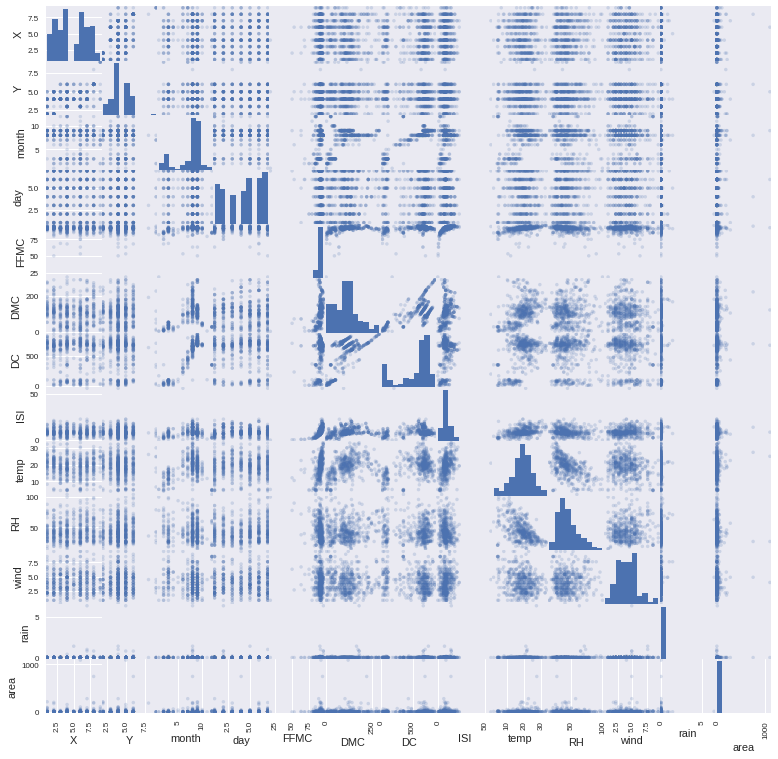

In [1]:
#Tin Nguyen

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#importing the data set:
dataframes = pd.read_csv("forestfires.csv")

#data proprocessing:

#replacing string values by numerical values:
dataframes.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),
                        (1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
dataframes.day.replace(('mon','tue','wed','thu','fri','sat','sun'),
                       (1,2,3,4,5,6,7), inplace=True)
train_cv = 1*dataframes
#shape of our data:
print('Dataset dimention: ',dataframes.shape)
#visualize the data for analysis:
pd.scatter_matrix(dataframes, alpha=0.2, figsize=(13, 13), diagonal='hist', grid=True)
plt.show()

In [2]:
#a quick look at the dataset:
dataframes.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


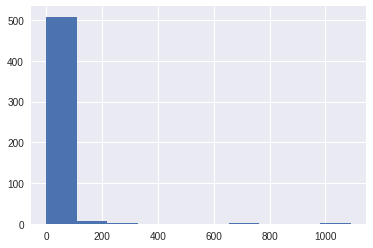

In [3]:
#zoom-in graph of area distribution:
dataframes['area'].hist()

We can see that the target is pretty skew toward 0 and also:

In [4]:
dataframes['area'].value_counts().sort_index()

0.00       247
0.09         1
0.17         1
0.21         1
0.24         1
0.33         1
0.36         1
0.41         1
0.43         2
0.47         1
0.52         2
0.54         1
0.55         1
0.61         1
0.68         2
0.71         1
0.72         1
0.75         1
0.76         1
0.77         1
0.79         1
0.90         2
0.95         1
0.96         1
1.01         1
1.07         1
1.09         1
1.10         1
1.12         1
1.19         1
          ... 
42.87        1
43.32        1
46.70        1
48.55        1
49.37        1
49.59        1
51.78        1
54.29        1
56.04        1
58.30        1
61.13        1
64.10        1
70.32        1
70.76        1
71.30        1
82.75        1
86.45        1
88.49        1
95.18        1
103.39       1
105.66       1
154.88       1
174.63       1
185.76       1
196.48       1
200.94       1
212.88       1
278.53       1
746.28       1
1090.84      1
Name: area, Length: 251, dtype: int64

There are only 5 big data from 200 to 1090. Others are relatively small. It also have a big variance. This is so far would be proven a challenge in fitting this.

In [5]:
dataframes['area'].var()

4052.063224823444

In [6]:
#correlation to area:
dataframes.corr()['area']

X        0.063385
Y        0.044873
month    0.056496
day      0.023226
FFMC     0.040122
DMC      0.072994
DC       0.049383
ISI      0.008258
temp     0.097844
RH      -0.075519
wind     0.012317
rain    -0.007366
area     1.000000
Name: area, dtype: float64

Most of these values are very close to 0. which means they are very scattered and there's very small linear relationship between area and all other features.

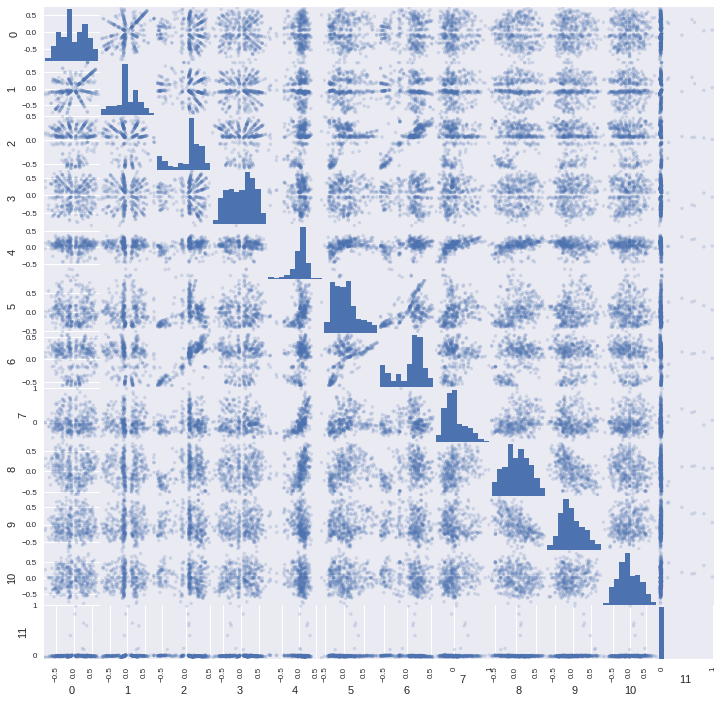

In [7]:
#continue preprocessing:

from sklearn.model_selection import train_test_split
# split original data into training and test set 80/20
train, test = train_test_split(dataframes, test_size=0.2)

# separate X and target for both train and test
train_target = train.pop('area')
test_target = test.pop('area')

from sklearn.preprocessing import StandardScaler, Normalizer
#perform scaling and normalize the data:
ss = StandardScaler()
train = ss.fit_transform(train)
test = ss.transform(test)

nm = Normalizer()
train = nm.fit_transform(train)
test = nm.transform(test)

#revisualize our training data:
pd.scatter_matrix(pd.DataFrame(train), alpha=0.2, figsize=(12, 12), diagonal='hist')
plt.show()

We can see that most of our training input now have kinda a Gaussian distribution apart from the rain amount (column 11). This would impove our regession task compare to what we had originaly.

In [0]:
#let's start the regression task
models = []
#linear models:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
models.append(('Linear Regression', LinearRegression(fit_intercept=True)))
models.append(('Ridge', Ridge(alpha=1, fit_intercept=True, normalize=True)))
models.append(('Lasso', Lasso(alpha=1, fit_intercept=True, normalize=True)))
models.append(('ElasticNet', ElasticNet(normalize=True)))
#SVM
from sklearn.svm import SVR
models.append(('SVM', SVR(kernel='rbf', C=1, gamma='auto')))
#K-nearest neighbor
from sklearn.neighbors import KNeighborsRegressor
models.append(('KNN', KNeighborsRegressor(n_neighbors=10, leaf_size=50)))
#random forest related models:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
models.append(('Bagging', BaggingRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Extra Trees', ExtraTreesRegressor()))
#decision tree
from sklearn.tree import DecisionTreeRegressor
models.append(('Decision Tree', DecisionTreeRegressor()))
#fully connected neural network
from sklearn.neural_network import MLPRegressor
models.append(('NN', MLPRegressor(solver = 'sgd',activation = 'relu', hidden_layer_sizes=(5,10),
                   verbose = False, max_iter=9999, tol=1e-6, alpha = 0.00001)))

In [9]:
#fit and evaluate the model
from sklearn.metrics import mean_absolute_error
meanError=[]
print('mean absolute error:')
for name, rgn in models:
    rgn.fit(train, train_target)
    print(name)
    print(mean_absolute_error(rgn.predict(test), test_target))
    meanError.append((name, mean_absolute_error(rgn.predict(test), test_target)))
meanError=np.array(meanError)

mean absolute error:
Linear Regression
25.80902531241821
Ridge
24.08170935536551
Lasso
23.74159131123114
ElasticNet
23.74159131123114
SVM
19.17577208047496
KNN
27.61558653846154
Bagging
29.316888621794874
Random Forest
28.16568381410256
Extra Trees
24.575360576923075
Decision Tree
23.040624999999995
NN
23.127087764313654


To further make our result better, we did cross validation with each model running 100 times and getting the average error of each model:

In [0]:
from sklearn.model_selection import cross_val_score
target_cv = train_cv.pop('area')

In [11]:
for name, rgn in models:
  print(name)
  temp = cross_val_score(rgn, train_cv, target_cv, cv=100, scoring='neg_mean_absolute_error')
  print(np.average(abs(temp)))

Linear Regression
20.237984005193358
Ridge
19.10292561241726
Lasso
18.845695749908263
ElasticNet
18.845695749908263
SVM
13.258082459474185
KNN
21.033597666666665
Bagging
25.476626242857147
Random Forest
22.96412093333333
Extra Trees
27.284292333333333
Decision Tree
26.938729999999996
NN
4.877857874507301e+47
